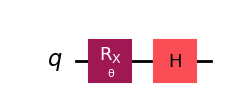

In [160]:
import numpy as np
from qiskit.circuit import QuantumCircuit, Parameter
from gymnasium.spaces import Box
from rl_qoc import (
    CustomPPO,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
    GateTargetConfig,
    QEnvConfig,
    ExecutionConfig,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig

θ = Parameter("θ")
qc = QuantumCircuit(1)
qc.rx(θ, 0)
qc.h(0)

qc.draw("mpl")

In [161]:
θ_val = np.pi

In [162]:
from qiskit_aer.noise import NoiseModel, coherent_unitary_error
from qiskit.circuit.library import RXGate

γ = 0.01
noisy_unitary = RXGate(γ * θ_val).to_matrix()
noise_model = NoiseModel(basis_gates=["h", "rx", "rz", "t", "s", "sdg", "tdg", "u"])
noise_model.add_all_qubit_quantum_error(coherent_unitary_error(noisy_unitary), "rx")

In [163]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2

backend = GenericBackendV2(
    1,
    ["h", "rx", "rz", "t", "s", "sdg", "tdg", "u", "reset"],
    calibrate_instructions=True,
    control_flow=True,
)
backend = AerSimulator.from_backend(backend, noise_model=noise_model)

In [147]:
# Define target gate
target = GateTargetConfig(physical_qubits=[0], gate="h")

In [164]:
print(backend.target)

Target: Generic Target with 1 qubits
Number of qubits: 1
Instructions:
	h
		(0,):
			Duration: 4.1292e-08 sec.
			Error Rate: 9.81085e-05
			With pulse schedule calibration
	rx
		(0,):
			Duration: 5.3724e-08 sec.
			Error Rate: 9.46079e-05
			With pulse schedule calibration
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	t
		(0,):
			Duration: 4.0404e-08 sec.
			Error Rate: 9.20436e-05
			With pulse schedule calibration
	s
		(0,):
			Duration: 5.1504e-08 sec.
			Error Rate: 9.57454e-05
			With pulse schedule calibration
	sdg
		(0,):
			Duration: 3.3744e-08 sec.
			Error Rate: 9.23413e-05
			With pulse schedule calibration
	tdg
		(0,):
			Duration: 4.3068e-08 sec.
			Error Rate: 9.74138e-05
			With pulse schedule calibration
	u
		(0,):
			Duration: 5.4612e-08 sec.
			Error Rate: 9.26898e-05
			With pulse schedule calibration
	reset
		(0,):
	delay
		(0,):
	measure
		(0,):
			Duration: 8.18958e-07 sec.
			Error Rate: 0.00217779
			With pulse schedule 

In [148]:
# Define parametrized circuit


def apply_parametrized_circuit(qc: QuantumCircuit, params, q_reg, **kwargs):
    my_qc = qc.copy_empty_like(name="h_cal")
    optimal_params = [np.pi / 2, 0.0, np.pi]
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]
    my_qc.u(*new_params, q_reg[0])

    qc.append(my_qc.to_gate(label=my_qc.name), q_reg)


qiskit_config = QiskitConfig(
    apply_parametrized_circuit,
    backend,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)

In [149]:
# Define the quantum environment
action_space = Box(low=-0.5, high=0.5, shape=(3,), dtype=np.float32)
env_metadata = {"γ": γ, "θ": θ_val}
training_config = QEnvConfig(
    target=target,
    backend_config=qiskit_config,
    reward_config="channel",
    execution_config=ExecutionConfig(
        batch_size=32, sampling_paulis=100, n_shots=10000, n_reps=9
    ),
    action_space=action_space,
    env_metadata=env_metadata,
)

In [150]:
q_env = ContextAwareQuantumEnvironment(
    training_config, circuit_context=qc.assign_parameters({θ: θ_val})
)
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

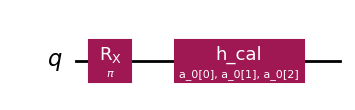

In [151]:
q_env.circuits[0].draw("mpl")

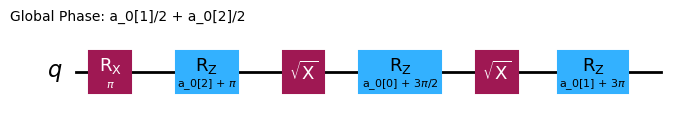

In [152]:
from qiskit import transpile

transpile(q_env.circuits[0], basis_gates=["ry", "rz", "sx", "rx"]).draw("mpl")

In [153]:
from rl_qoc.agent import PPOConfig

ppo_config = PPOConfig.from_yaml("agent_config.yaml")

In [154]:
from rl_qoc.agent import TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(ppo_config, rescaled_env, save_data=False)

In [155]:
total_updates = 5
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = True

run_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

In [156]:
print(q_env.backend.target)

Target: Generic Target with 1 qubits
Number of qubits: 1
Instructions:
	h
		(0,):
			Duration: 4.1736e-08 sec.
			Error Rate: 9.49828e-05
			With pulse schedule calibration
	rx
		(0,):
			Duration: 5.5056e-08 sec.
			Error Rate: 9.6191e-05
			With pulse schedule calibration
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	t
		(0,):
			Duration: 5.3724e-08 sec.
			Error Rate: 9.90911e-05
			With pulse schedule calibration
	s
		(0,):
			Duration: 4.2846e-08 sec.
			Error Rate: 9.78442e-05
			With pulse schedule calibration
	sdg
		(0,):
			Duration: 4.2402e-08 sec.
			Error Rate: 9.97847e-05
			With pulse schedule calibration
	tdg
		(0,):
			Duration: 5.1726e-08 sec.
			Error Rate: 9.05355e-05
			With pulse schedule calibration
	u
		(0,):
			Duration: 3.0192e-08 sec.
			Error Rate: 9.74803e-05
			With pulse schedule calibration
	reset
		(0,):
	delay
		(0,):
	measure
		(0,):
			Duration: 8.34498e-07 sec.
			Error Rate: 0.00167885
			With pulse schedule c

In [157]:
ppo_agent.train(run_config, train_settings)


 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9990681014632901
Hardware runtime taken: 0.7255887360000001 min  43.53532416 seconds
Sending Estimator job...
Time for running 0.07589411735534668
Finished Estimator job
Reward (avg): 0.24072705715303658 Std: 0.3533584567161784

 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9995938678878004
Hardware runtime taken: 1.5116432000000002 min  30.698592000000005 seconds
Sending Estimator job...
Time for running 0.038433074951171875
Finished Estimator job
Reward (avg): 0.22423901392478077 Std: 0.33105236612980243

 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9996714514113081
Hardware runtime taken: 2.317852906666667 min  19.071174400000018 seconds
Sending Estimator job...
Time for running 0.03799700736999512
Finished Estimator job
Reward (avg): 0.3369713332650596 Std: 

{'avg_reward': [0.24072705715303658,
  0.22423901392478077,
  0.3369713332650596,
  0.3633683249098575],
 'fidelity_history': [0.9990681014632901,
  0.9995938678878004,
  0.9996714514113081,
  0.9998297673010769],
 'hardware_runtime': [43.53532416, 47.16326784, 48.3725824, 50.18655424],
 'total_shots': [23040000, 24960000, 25600000, 26560000],
 'total_updates': [],
 'clipped_mean_action_0': [tensor(0.0331),
  tensor(0.0163),
  tensor(0.0090),
  tensor(-0.0048)],
 'mean_action_0': [tensor(0.0662),
  tensor(0.0325),
  tensor(0.0179),
  tensor(-0.0096)],
 'std_action_0': [tensor(0.5183),
  tensor(0.5040),
  tensor(0.4885),
  tensor(0.4739)],
 'clipped_mean_action_1': [tensor(0.0316),
  tensor(0.0035),
  tensor(0.0022),
  tensor(-0.0018)],
 'mean_action_1': [tensor(0.0631),
  tensor(0.0069),
  tensor(0.0045),
  tensor(-0.0036)],
 'std_action_1': [tensor(0.4703),
  tensor(0.4689),
  tensor(0.4684),
  tensor(0.4647)],
 'clipped_mean_action_2': [tensor(0.0241),
  tensor(0.0312),
  tensor(0.02

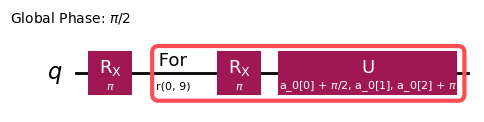

In [158]:
q_env.pubs[0].circuit.draw("mpl")

In [159]:
from qiskit.qasm3 import dumps as qasm_dumps

print(qasm_dumps(q_env.pubs[0].circuit))

OPENQASM 3.0;
include "stdgates.inc";
input float[64] _a_0_0_;
input float[64] _a_0_1_;
input float[64] _a_0_2_;
rx(pi) $0;
for _ in [0:8] {
  rx(pi) $0;
  U(_a_0_0_ + pi/2, _a_0_1_, _a_0_2_ + pi) $0;
}



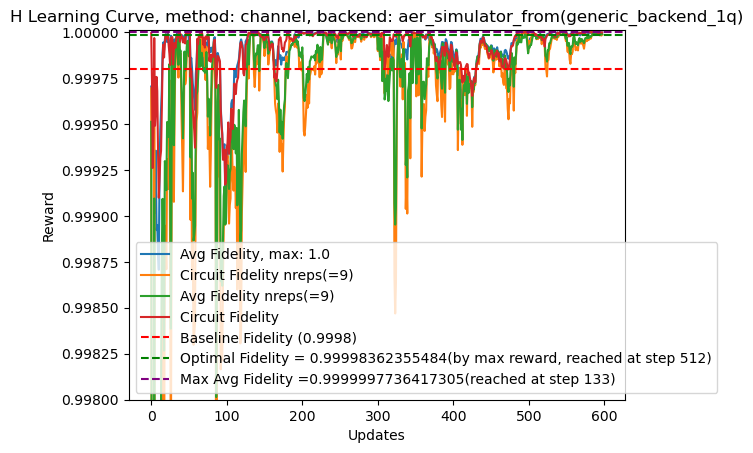

In [115]:
# Plotting the learning curve
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = np.round(np.max(mean_rewards), 4)
arg_max_mean = np.argmax(mean_rewards)
baseline_fidelity = np.round(
    q_env.simulate_circuit(
        q_env.circuits[0], np.zeros((1, 3)), update_env_history=False
    ),
    4,
)[0]

plot_reward = False
plot_fidelity = True
plot_circuit_fidelity = True
plot_fidelity_nreps = True
plot_circuit_fidelity_nreps = True

if plot_reward:
    plt.plot(mean_rewards, label=f"Reward, max: {max_mean}")
if plot_fidelity:
    plt.plot(
        q_env.fidelity_history,
        label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
    )
if plot_circuit_fidelity_nreps:
    plt.plot(
        q_env.circuit_fidelity_history_nreps,
        label=f"Circuit Fidelity nreps(={q_env.n_reps})",
    )
if plot_fidelity_nreps:
    plt.plot(
        q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})"
    )
if plot_circuit_fidelity:
    plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.array([q_env.optimal_action]), update_env_history=False
    ),
    label=f"Optimal Fidelity = {q_env.fidelity_history[arg_max_mean]}(by max reward, reached at step {arg_max_mean})",
    color="green",
    linestyle="--",
)
plt.axhline(
    np.max(q_env.fidelity_history),
    label=f"Max Avg Fidelity ={np.max(q_env.fidelity_history)}(reached at step {np.argmax(q_env.fidelity_history)})",
    color="purple",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env.config.backend.name if q_env.config.backend is not None else 'No backend'}"
)
plt.ylim(0.998, 1.00001)
plt.legend()

In [116]:
q_env.optimal_action

array([ 0.00083911, -0.04055472, -0.00375056], dtype=float32)

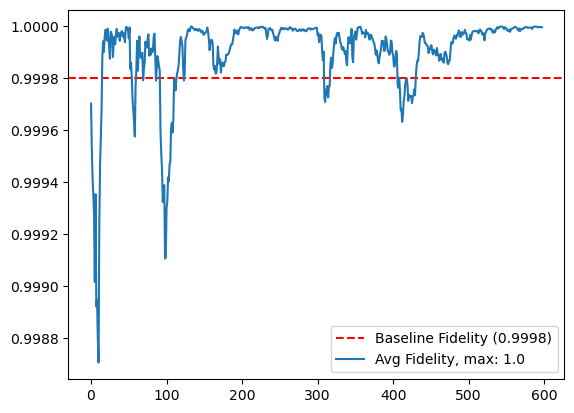

In [117]:
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.plot(
    q_env.fidelity_history,
    label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
)
plt.legend()

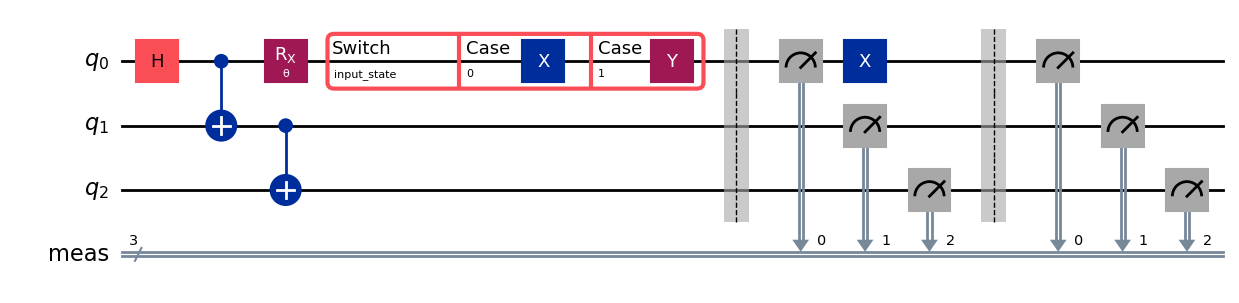

In [4]:
from qiskit.circuit import QuantumCircuit, ClassicalRegister, QuantumRegister, Parameter
from qiskit.circuit.classical.types import Uint, Bool
from qiskit.primitives import StatevectorSampler
from qiskit_aer.primitives import SamplerV2

q = QuantumRegister(3, "q")
c1 = ClassicalRegister(1, "c1")
c2 = ClassicalRegister(1, "c2")
c3 = ClassicalRegister(1, "c3")
qc = QuantumCircuit(q)
var = qc.add_input("input_state", Uint(2))
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.rx(Parameter("θ"), 0)
with qc.switch(var) as case:
    with case(0):
        qc.x(0)
    with case(1):
        qc.y(0)
qc.measure_all()
qc.x(0)
qc.measure_all(add_bits=False)
qc.draw("mpl")

In [12]:
from qiskit.circuit import ParameterVector

param_vec = ParameterVector("θ", 3)
param_vec[0].subs({param_vec[0]: 1})

ParameterVector(name='θ', length=3)

In [5]:
from qiskit.qasm3 import dumps as qasm_dumps

print(qasm_dumps(qc))

OPENQASM 3.0;
include "stdgates.inc";
input float[64] θ;
input uint[2] input_state;
bit[3] meas;
int switch_dummy;
qubit[3] q;
h q[0];
cx q[0], q[1];
cx q[1], q[2];
rx(θ) q[0];
switch_dummy = input_state;
switch (switch_dummy) {
  case 0 {
    x q[0];
  }
  case 1 {
    y q[0];
  }
}
barrier q[0], q[1], q[2];
meas[0] = measure q[0];
meas[1] = measure q[1];
meas[2] = measure q[2];
x q[0];
barrier q[0], q[1], q[2];
meas[0] = measure q[0];
meas[1] = measure q[1];
meas[2] = measure q[2];



In [268]:
sampler = SamplerV2()
job = sampler.run([(qc, [0.3, 0.2, 0.1])])
result = job.result()
result

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(3,), num_shots=1024, num_bits=3>), shape=(3,)), metadata={'shots': 1024, 'circuit_metadata': {}, 'simulator_metadata': {'time_taken_parameter_binding': 6.3292e-05, 'max_memory_mb': 18432, 'time_taken_execute': 0.092705291, 'omp_enabled': True, 'max_gpu_memory_mb': 0, 'parallel_experiments': 1}})], metadata={'version': 2})

In [273]:
result[0].data.meas[0]

BitArray(<shape=(), num_shots=1024, num_bits=3>)

In [274]:
result[0].data.meas[0].postselect([0], 0)

BitArray(<shape=(), num_shots=509, num_bits=3>)

In [278]:
result[0].data.meas.get_counts(0)

{'001': 506, '110': 499, '000': 10, '111': 9}

In [201]:
qc.clbits

[Clbit(ClassicalRegister(3, 'meas'), 0),
 Clbit(ClassicalRegister(3, 'meas'), 1),
 Clbit(ClassicalRegister(3, 'meas'), 2)]